# Solving CartPole-v0 with the policy gradient algorithm REINFOCE

The following is an implementation of the [REINFOCE]() algorithm described in ([Policy Gradient Methods for
Reinforcement Learning with Function Approximation](https://papers.nips.cc/paper/1713-policy-gradient-methods-for-reinforcement-learning-with-function-approximation.pdf)).

The environment Cartpole-v0 is used to test the algorithm, was created by OpenAi and is described in more detail here cartpolev0 and here doc.

If the algorithm manages to execute the simulation of the cartpole for a 100 episodes, keeping it balanced for more then 195 steps the environment is said to be solved.

In [81]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm

In [37]:
def print_step(state, reward, done, info):
    print(f"state: {state},\nreward: {reward},\ndone: {done},\ninfo: {info}")

A quick look at the environment:

In [38]:
env = gym.make('CartPole-v0')

In [39]:
initial_state = env.reset()
action = env.action_space.sample()
state, reward, done, info = env.step(action)
print_step(state, reward, done, info)

state: [-0.03372556 -0.16362425  0.02842715  0.26192135],
reward: 1.0,
done: False,
info: {}


In [40]:
def running_mean(x, N=50):
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y

Create the policy network

In [89]:
class PolicyNetwork(nn.Module):
    
    def __init__(self, 
                 input_dim=4, 
                 hidden_dim=[128, 64], 
                 output_dim=2):
        super(PolicyNetwork, self).__init__()
        self.output_dim = output_dim
        self.input_layer = nn.Linear(input_dim, hidden_dim[0])
        
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dim) - 1):
            hidden_layer = nn.Linear(hidden_dim[i], hidden_dim[i+1])
            self.hidden_layers.append(hidden_layer)
        
        self.output_layer = nn.Linear(hidden_dim[-1], output_dim)
        
        
    def forward(self, state):
        
        x = F.relu(self.input_layer(state))
        for hidden in self.hidden_layers:
            x = F.leaky_relu(hidden(x))
        x = F.softmax(self.output_layer(x), dim=-1)
        
        return x
    
model = PolicyNetwork()
learning_rate = 0.009
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [90]:
initial_state = env.reset()
pred = model(torch.from_numpy(initial_state).float())
action = np.random.choice(np.array([0,1]), p=pred.data.numpy())
state, reward, done, info = env.step(action)
print("pred: ",pred)
print_step(state, reward, done, info)

pred:  tensor([0.4820, 0.5180], grad_fn=<SoftmaxBackward>)
state: [ 0.02407491 -0.17618054  0.04156761  0.35399204],
reward: 1.0,
done: False,
info: {}


In [91]:
def discount_rewards(rewards, gamma=.99):
    lenr = len(rewards)
    discounted_return = torch.pow(gamma, torch.arange(lenr).float()) * rewards
    discounted_return /= discounted_return.max()
    return discounted_return

In [92]:
def loss_fn(preds, rewards):
    return -1 * torch.sum(rewards * torch.log(preds))

Training the REINFORCE ALGORITHM

In [93]:
MAX_DUR = 200
MAX_EPISODES = 5000
gamma = 0.99

action_space = np.array([0,1])
score = []

scores_window = deque(maxlen=100)

def interact_with_environment():
    #start the environment.
    state = env.reset()
    done = False
    experiences = []
    episode_reward = 0
    #interacting with the environment, continue untill the pole falls (done == True) or max 200 steps. 
    for t in range(MAX_DUR):
        action_prob = model(torch.from_numpy(state).float()).detach()
        action = np.random.choice(action_space, p=action_prob.data.numpy())
        next_state, reward, done, info = env.step(action)
        
        experiences.append((state, action, reward * (1-done)))
        episode_reward += 1
        state = next_state
        # the pole fell. 
        if done:
            break
    return experiences, episode_reward
    
def train_model(experiences):
    # train the model
    
    reward_batch = torch.Tensor([r for (s,a,r) in experiences]).flip(dims=(0,))
    discounted_reward = discount_rewards(reward_batch)

    state_batch = torch.Tensor([s for (s,a,r) in experiences])
    action_batch = torch.Tensor([a for (s,a,r) in experiences])
    pred_batch = model(state_batch)
    prob_batch = pred_batch.gather(dim=1, index=action_batch.long().view(-1,1)).squeeze()

    loss = loss_fn(prob_batch, discounted_reward)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    
    
for episode in tqdm(range(MAX_EPISODES)):

    experiences, rewards = interact_with_environment()
    scores_window.append(rewards)
    ep_len = len(experiences)
    score.append(ep_len)

    train_model(experiences)
    
    if episode % 100 == 0:
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
    if np.mean(scores_window) >= 195:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode - 100,
                                                                             np.mean(scores_window)))
        torch.save(agent.model.state_dict(), 'checkpoint.pth')
        break
    
        

Episode 0	Average Score: 30.00
Episode 100	Average Score: 42.90
Episode 200	Average Score: 23.56
Episode 300	Average Score: 14.98
Episode 400	Average Score: 9.32
Episode 500	Average Score: 9.31
Episode 600	Average Score: 9.32
Episode 700	Average Score: 9.34
Episode 800	Average Score: 9.41
Episode 900	Average Score: 9.30
Episode 1000	Average Score: 9.30
Episode 1100	Average Score: 9.34
Episode 1200	Average Score: 9.35
Episode 1300	Average Score: 9.31
Episode 1400	Average Score: 9.29
Episode 1500	Average Score: 9.39
Episode 1600	Average Score: 9.30
Episode 1700	Average Score: 9.38
Episode 1800	Average Score: 9.44
Episode 1900	Average Score: 9.40
Episode 2000	Average Score: 9.44
Episode 2100	Average Score: 9.37
Episode 2200	Average Score: 9.33
Episode 2300	Average Score: 9.33
Episode 2400	Average Score: 9.33
Episode 2500	Average Score: 9.34
Episode 2600	Average Score: 9.28
Episode 2700	Average Score: 9.39
Episode 2800	Average Score: 9.31
Episode 2900	Average Score: 9.34
Episode 3000	Avera

In [77]:
score = np.array(score)
avg_score = running_mean(score, 50)

plt.figure(figsize=(10,7))
plt.ylabel("Episode Duration",fontsize=22)
plt.xlabel("Training Epochs",fontsize=22)
plt.plot(avg_score, color='green')


ValueError: negative dimensions are not allowed

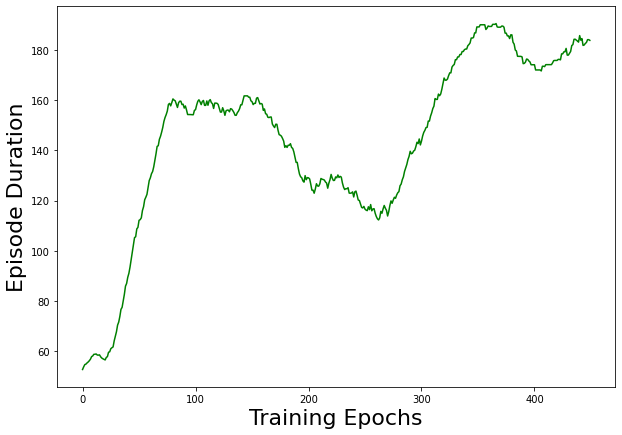

In [12]:
score1 = np.array(score)
avg_score1 = running_mean(score1, 50)

plt.figure(figsize=(10,7))
plt.ylabel("Episode Duration",fontsize=22)
plt.xlabel("Training Epochs",fontsize=22)
plt.plot(avg_score1, color='green')